In [9]:
%cd '/mnt/c/Users/malin/Documents/Facultate/honours/UMCG/ICU_Augment_and_Detect'

/mnt/c/Users/malin/Documents/Facultate/honours/UMCG/ICU_Augment_and_Detect


In [10]:
import matplotlib.pyplot as plt
import cv2
import os
import sys
import numpy as np
import pickle
import csv
import seaborn as sn
import pandas as pd
sys.path.append(os.getcwd())


In [3]:
save_path = 'categorization/model_saves/'

def load_histories(save_path):
    history = '/history.pickle'
    models = ["mouth", "face", "skin", "eyes", "stacked"]
    all_histories = {}
    for model in models:
        hist_path = save_path + str(model) + history
        if os.path.isfile(hist_path):
            print(hist_path)
            hist_file = open(hist_path, "rb")
            all_histories[model] = pickle.load(hist_file)
    return all_histories

all_histories = load_histories(save_path)

categorization/model_saves/mouth/history.pickle
categorization/model_saves/face/history.pickle
categorization/model_saves/skin/history.pickle
categorization/model_saves/eyes/history.pickle
categorization/model_saves/stacked/history.pickle


In [4]:
print(all_histories["mouth"])
print(all_histories["face"])

{'loss': [0.22822600446733426, 0.06320808643732438, 0.08138701613463553], 'accuracy': [0.9032922, 0.97325104, 0.97119343], 'auc': [0.96832144, 0.9976201, 0.99541306], 'false_positives': [62.0, 11.0, 16.0], 'true_positives': [540.0, 557.0, 560.0], 'true_negatives': [338.0, 389.0, 384.0], 'false_negatives': [32.0, 15.0, 12.0], 'val_loss': [9.52386005108173, 21.996426508976864, 9.151463361886831], 'val_accuracy': [0.34615386, 0.5, 0.5192308], 'val_auc': [0.35281062, 0.5, 0.5769231], 'val_false_positives': [23.0, 26.0, 0.0], 'val_true_positives': [15.0, 26.0, 1.0], 'val_true_negatives': [3.0, 0.0, 26.0], 'val_false_negatives': [11.0, 0.0, 25.0]}
{'loss': [0.30678219725320366, 0.11991046838186405, 0.09910994093221279], 'accuracy': [0.8446502, 0.94855964, 0.9701646], 'auc_1': [0.96786493, 0.9955004, 0.9953976], 'false_positives_1': [15.0, 11.0, 5.0], 'true_positives_1': [436.0, 533.0, 548.0], 'true_negatives_1': [385.0, 389.0, 395.0], 'false_negatives_1': [136.0, 39.0, 24.0], 'val_loss': [15

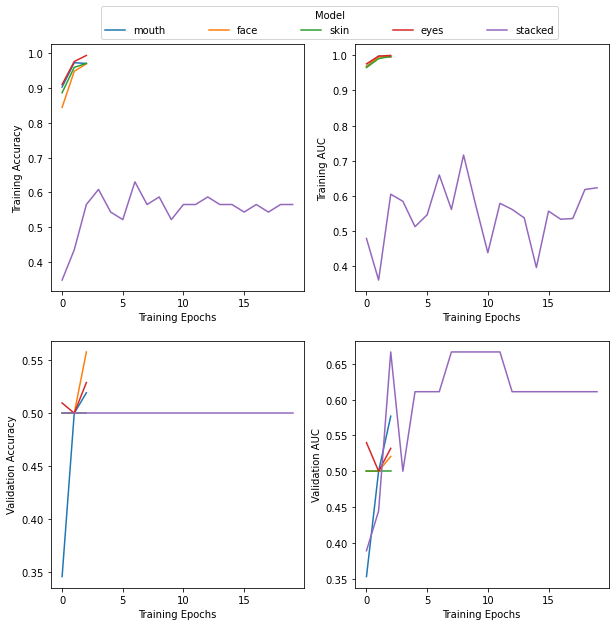

In [10]:
def plot_all_auc_acc(all_histories):

    fig = plt.figure(figsize=(10,10))

    plt.subplot(2,2,1)
    for key in all_histories:
        plt.plot(all_histories[key]["accuracy"], label = str(key))
    plt.xlim((0,2))
    plt.xlabel('Training Epochs')
    plt.ylabel('Training Accuracy')
    # plt.figure()
    # plt.legend()
    plt.legend(bbox_to_anchor=(0.2, 1.02, 1.8, .102), loc='lower left',
            ncol=5, mode="expand", borderaxespad=0., title = "Model")

    plt.subplot(2,2,2)
    i = 0
    for key in all_histories:
        if i == 0 or i == 4:
            search = "auc"
        else:
            search = "auc_" + str(i)
        plt.plot(all_histories[key][search], label = str(key))
        i +=1 
    plt.xlim((0,2))
    plt.xlabel('Training Epochs')
    plt.ylabel('Training AUC')
    # plt.figure()
    # plt.legend()

    plt.subplot(2,2,3)
    for key in all_histories:
        plt.plot(all_histories[key]["val_accuracy"], label = str(key))

    plt.xlim((0,2))
    plt.xlabel('Training Epochs')
    plt.ylabel('Validation Accuracy')
    # plt.figure()
    # plt.legend()

    plt.subplot(2,2,4)
    i = 0
    for key in all_histories:
        if i == 0 or i == 4:
            search = "val_auc"
        else:
            search = "val_auc_" + str(i)
        plt.plot(all_histories[key][search], label = str(key))
        i +=1 

    plt.xlim((0,2))
    plt.xlabel('Training Epochs')
    plt.ylabel('Validation AUC')
    # plt.legend()

    plt.savefig("data/plots/models_acc_auc.png")
    plt.show()

In [9]:
def print_raw(all_histories):
    with open("data/exact_values.csv", "w") as data_file:
        writer = csv.writer(data_file, delimiter=',')
        header = ['Model', 'Training Accuracy', 'Training AUC', 'Validation Accuracy', 'Validation AUC']
        writer.writerow(header)
        i = 0 
        for model in all_histories:
            final = len(all_histories[model]["accuracy"]) - 1
            if i == 0 or i == 4:
                auc = "auc"
                val_auc = "val_auc"
            else:
                auc = "auc_" + str(i)
                val_auc = "val_auc_" + str(i)
            row = [str(model), all_histories[model]["accuracy"][final], all_histories[model][auc][final], all_histories[model]["val_accuracy"][final], all_histories[model][val_auc][final]]
            writer.writerow(row)
            i += 1



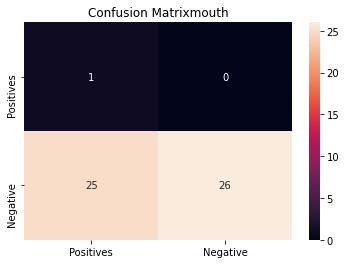

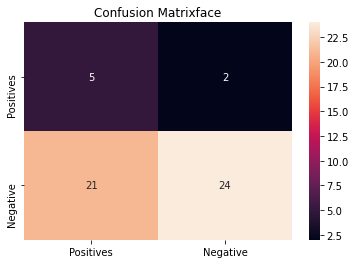

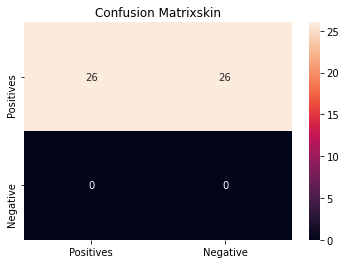

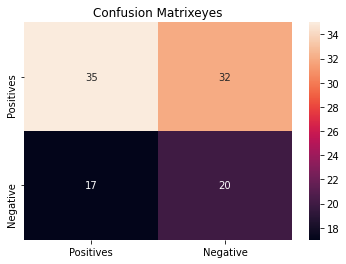

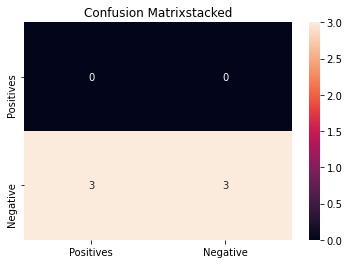

In [19]:
def plot_confusion_matrix(all_histories):
    i = 0
    for model in all_histories:
        final = len(all_histories[model]["accuracy"]) - 1
        fp = "val_false_positives"
        tp = "val_true_positives"
        tn = "val_true_negatives"
        fn = "val_false_negatives" 
        if i != 0 and i != 4:
            fp = fp + "_" + str(i)
            tp = tp + "_" + str(i)
            tn = tn + "_" + str(i)
            fn = fn + "_" + str(i) 
        matrix = [[all_histories[model][tp][final], all_histories[model][fp][final]],
                    [all_histories[model][fn][final], all_histories[model][tn][final]]]
        df_cm = pd.DataFrame(matrix, index = ["Positives", "Negative"],
              columns = ["Positives", "Negative"])
        ax = plt.axes()
        sn.heatmap(df_cm, annot=True, ax=ax)
        ax.set_title('Confusion Matrix_' + str(model))
        plt.show()
        # plt.matshow(matrix)
        i += 1

plot_confusion_matrix(all_histories)